# Выбор локации для скважины

**Содержание:**  
1. [Загрузка и подготовка данных](#load_and_info)  
 1.1. [Импорт библиотек](#import)  
 1.2. [Загрузка данных](#read)  
 1.3. [Общая информация](#info)  
 1.4. [Подготовка данных](#data_preparation)  
    
    
2. [Обучение и проверка модели](#teach_and_check)  
 
 
3. [Подготовка к расчёту прибыли](#profit_preparation)  


4. [Расчёт прибыли и рисков](#profit)  
 4.1. [Расчёт прибыли для двухсот лучших по прогнозам точек каждого региона](#profit_200_best)  
 4.2. [Расчёт рисков и прибыли для каждого региона](#profit_200_from_500)  


 
5. [Общий вывод](#final)  



**Заказчик исследования:** добывающая компания «ГлавРосГосНефть».  
**Цель исследования:** создание модели прогнозирования для определения региона, в котором добыча принесёт наибольшую прибыль.  

**Условия исследования:**  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);  
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;  
- Бюджет на разработку скважин в регионе — 10 млрд рублей;  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;  
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Исходные данные:**  
Исходные данные представлены в датасетах:  
- "geo_data_0.csv" - данные по первому региону;  
- "geo_data_1.csv" - данные по второму региону;  
- "geo_data_2.csv" - данные по третьему региону;  

В датасетах содержатся следующие данные:  
- id — уникальный идентификатор скважины;  
- f0, f1, f2 — три признака точек;  
- product — объём запасов в скважине в тыс. баррелей (целевой признак).  

## Загрузка и подготовка данных
<a id="load_and_info"></a>

### Импорт библиотек
<a id="import"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy import stats

### Загрузка данных
<a id="read"></a>

In [2]:
try:
    df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    df_geo_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

try:
    df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df_geo_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    
try:
    df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_geo_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Общая информация
<a id="info"></a>

Функция вывода общей инфомрации:

In [6]:
def inf(df_info):
    print()
    print('Общая информация:')
    display(df_info.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Описательная статистика строковых значений:')
    display(df_info.describe(include='object').T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_info.describe().T)
    print('_' * 50)
    print()
    print('Процент пропущенных значений:')
    display(df_info.isna().mean()*100)
    print('_' * 50)
    print()
    print('Случайная выборка датафрейма:')
    display(df_info.sample(n = 5, random_state = 0))
    print('_' * 100)
    print()
    print('Проверка на выбросы:')
    
    fig = plt.figure(figsize=(14, 14))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1 = sns.boxplot(x=df_info['f0'])
    ax1 = plt.title('Распределение значений признака f0') 

    ax2 = fig.add_subplot(2, 2, 2)
    ax2 = sns.boxplot(x=df_info['f1'])
    ax2 = plt.title('Распределение значений признака f1')

    ax3 = fig.add_subplot(2, 2, 3)
    ax3 = sns.boxplot(x=df_info['f2'])
    ax3 = plt.title('Распределение значений признака f2')

    ax4 = fig.add_subplot(2, 2, 4)
    ax4 = sns.boxplot(x=df_info['product'])
    ax4 = plt.title('Распределение значений целевого признака (product)')

    fig.tight_layout()
    plt.show()

Выводим информацию по первому региону:


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
id,100000,99990,fiKDv,2


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


__________________________________________________

Процент пропущенных значений:


id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

__________________________________________________

Случайная выборка датафрейма:


,id,f0,f1,f2,product
3582,zMatX,0.881376,0.273600,2.770651,49.723143
60498,muBEx,-0.991020,0.010620,3.233630,10.583795
53227,DMAPr,-0.987623,0.017871,5.005426,139.110613
21333,fasrx,2.081966,0.426730,2.638579,85.109875
3885,0XaIy,0.850498,0.473509,3.575604,39.726827


____________________________________________________________________________________________________

Проверка на выбросы:


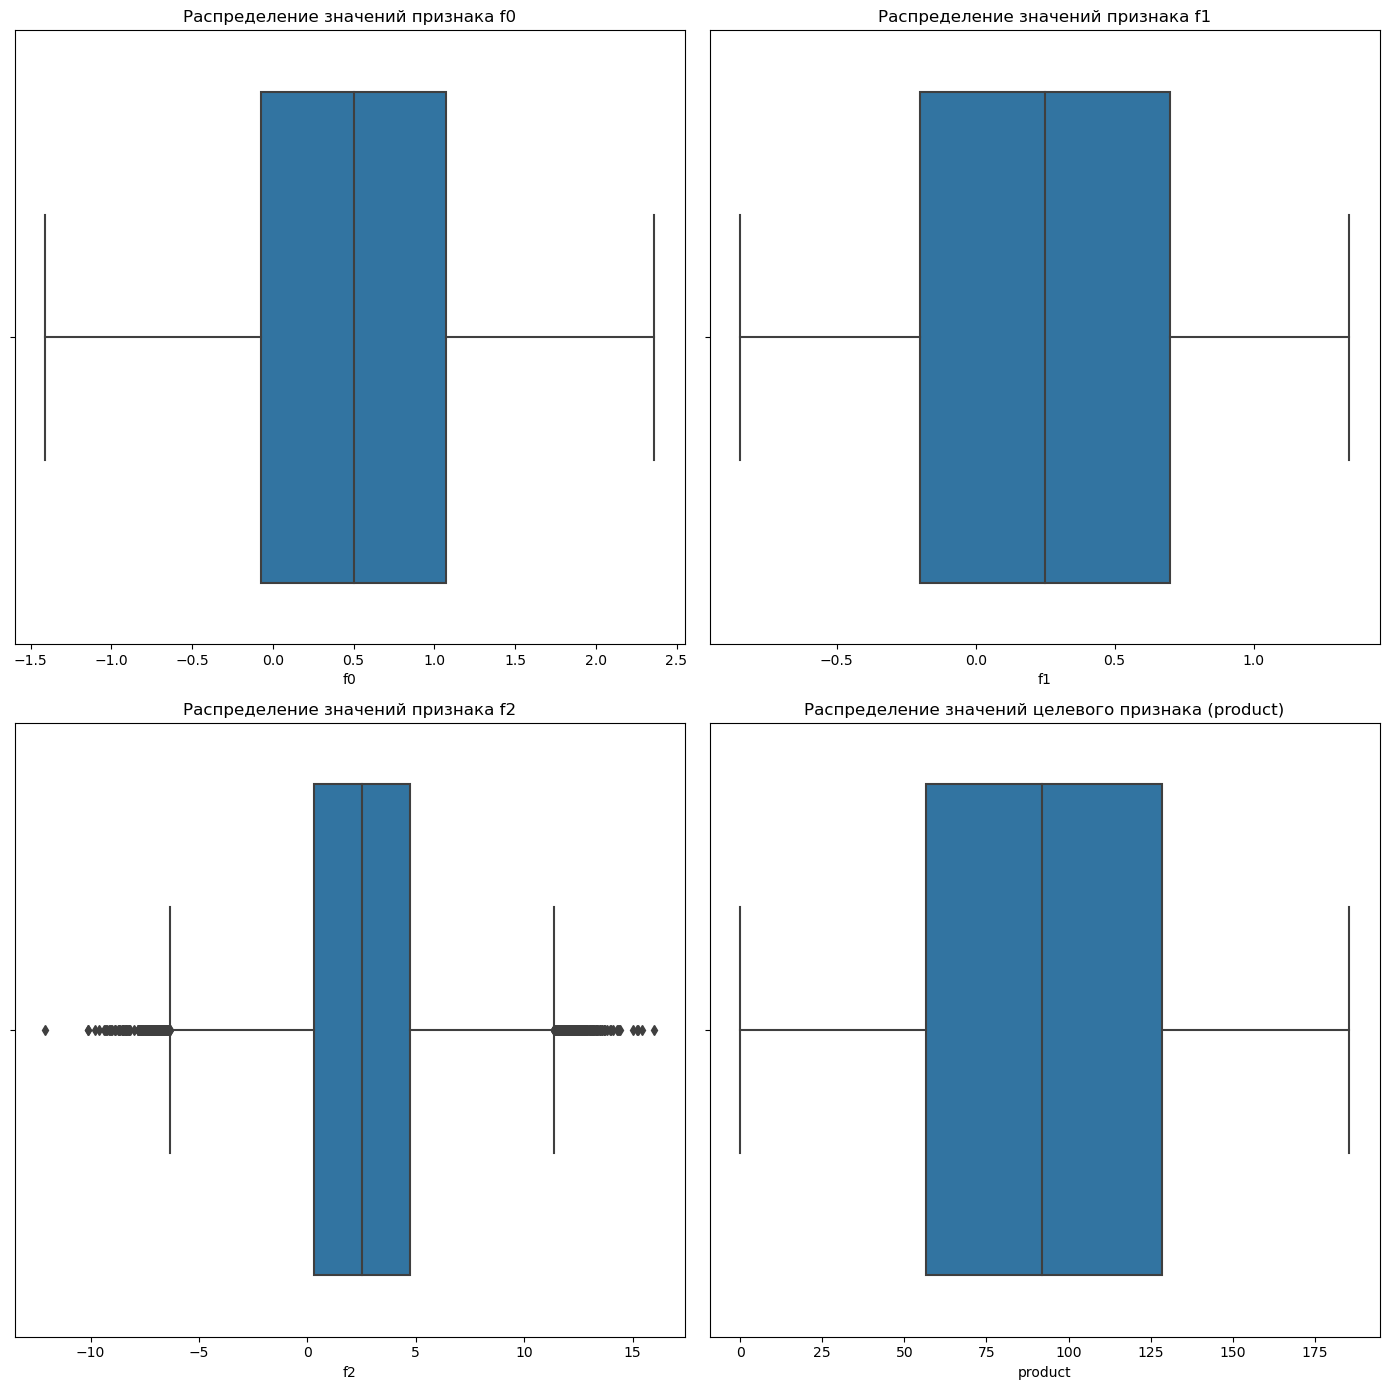

In [7]:
inf(df_geo_0)

В датафрейме 100000 строк и 5 столбцов.  
Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
Из 100000 значений "id" уникальных 99990: присутствуют дубликаты.  
Присутствуют выбросы по признаку "f2". 

Выводим информацию по второму региону:


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
id,100000,99996,wt4Uk,2


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


__________________________________________________

Процент пропущенных значений:


id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

__________________________________________________

Случайная выборка датафрейма:


,id,f0,f1,f2,product
3582,gnvG6,13.682535,-1.577749,4.999462,134.766305
60498,KGfJ0,-4.834251,-0.349029,4.996602,137.945408
53227,Km7yX,-7.287642,-4.184750,0.001329,3.179103
21333,bGQtv,-10.041103,-16.919151,3.999895,110.992147
3885,CuYNo,-8.650003,-4.526214,5.012777,137.945408


____________________________________________________________________________________________________

Проверка на выбросы:


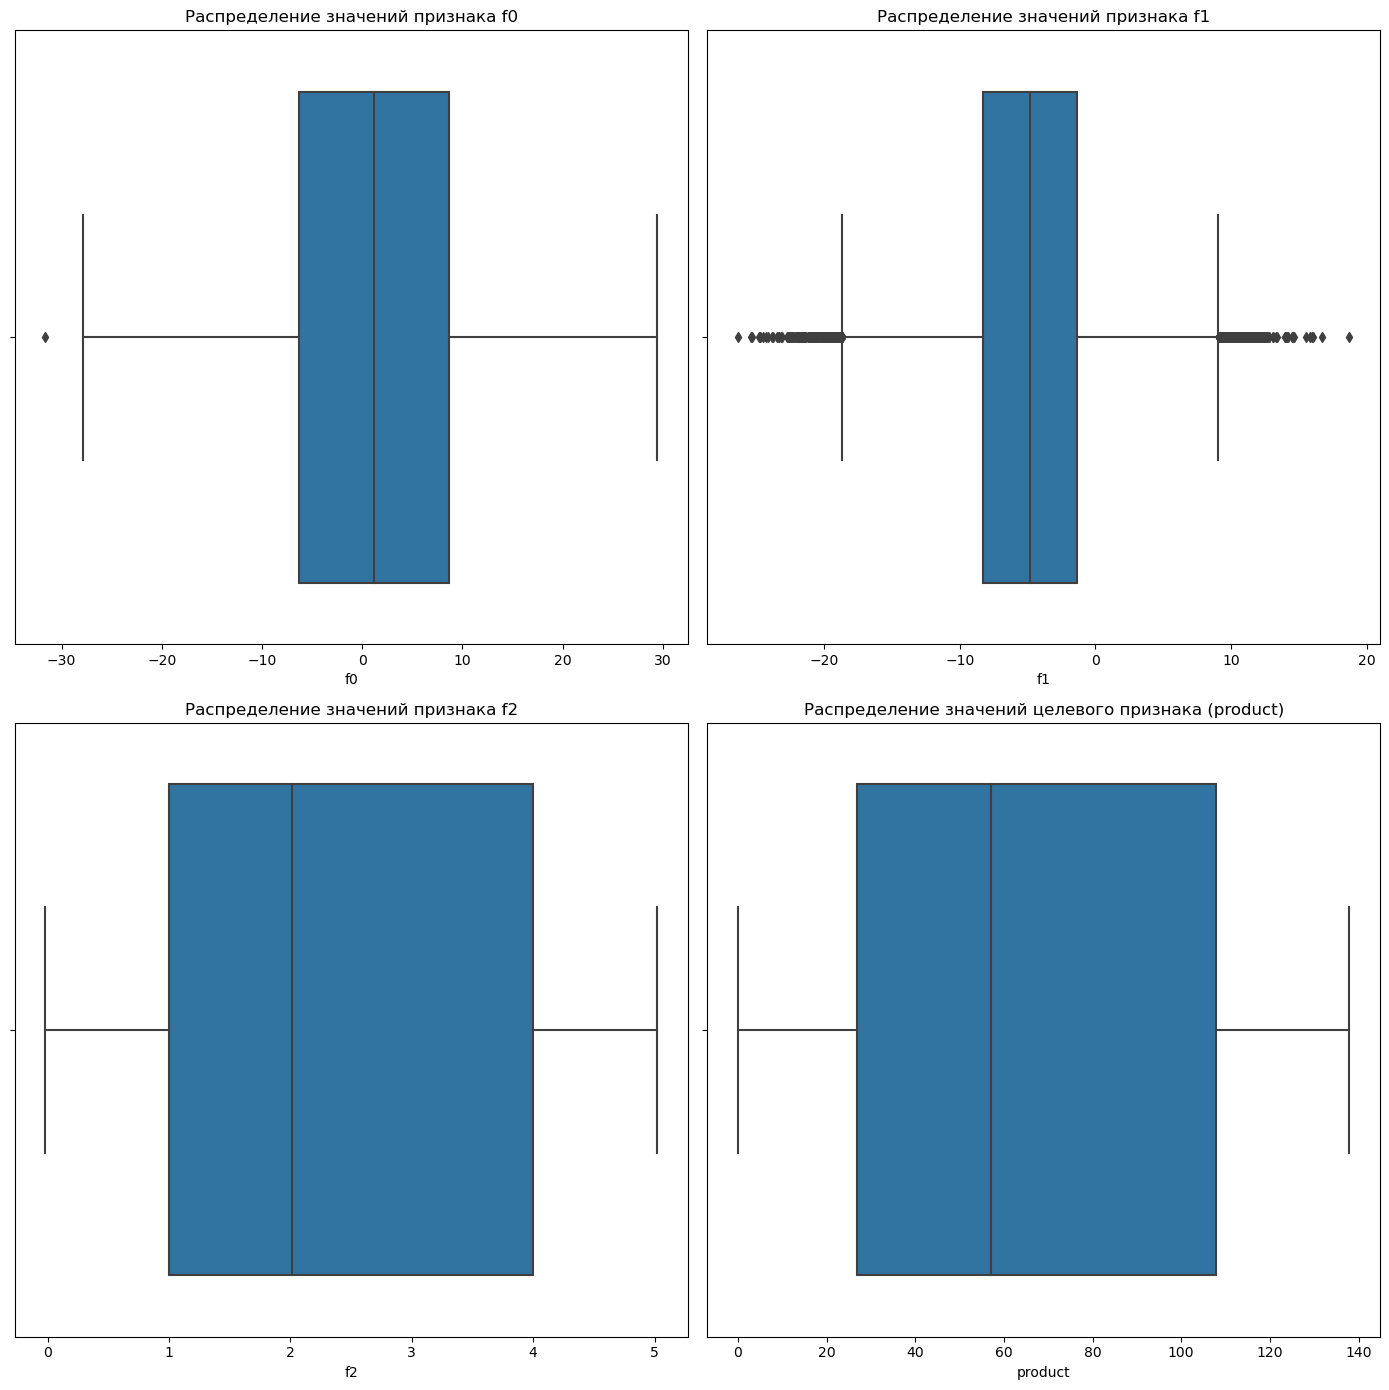

In [8]:
inf(df_geo_1)

В датафрейме 100000 строк и 5 столбцов.  
Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
Из 100000 значений "id" уникальных 99996: присутствуют дубликаты.  
Присутствуют выбросы по признакам "f0" и "f1".  

Выводим информацию по третьему региону:


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 9.0 MB


None

__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
id,100000,99996,VF7Jo,2


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


__________________________________________________

Процент пропущенных значений:


id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

__________________________________________________

Случайная выборка датафрейма:


,id,f0,f1,f2,product
3582,GdnWX,-0.838132,-0.968042,4.074363,129.102262
60498,z2rQ2,0.370981,-0.573846,-3.568113,61.285744
53227,vZROH,0.856767,1.441619,4.895820,65.026246
21333,6AgeD,1.989628,-1.343347,3.242798,62.334048
3885,nXQ8W,2.194257,-2.180922,1.699123,150.002134


____________________________________________________________________________________________________

Проверка на выбросы:


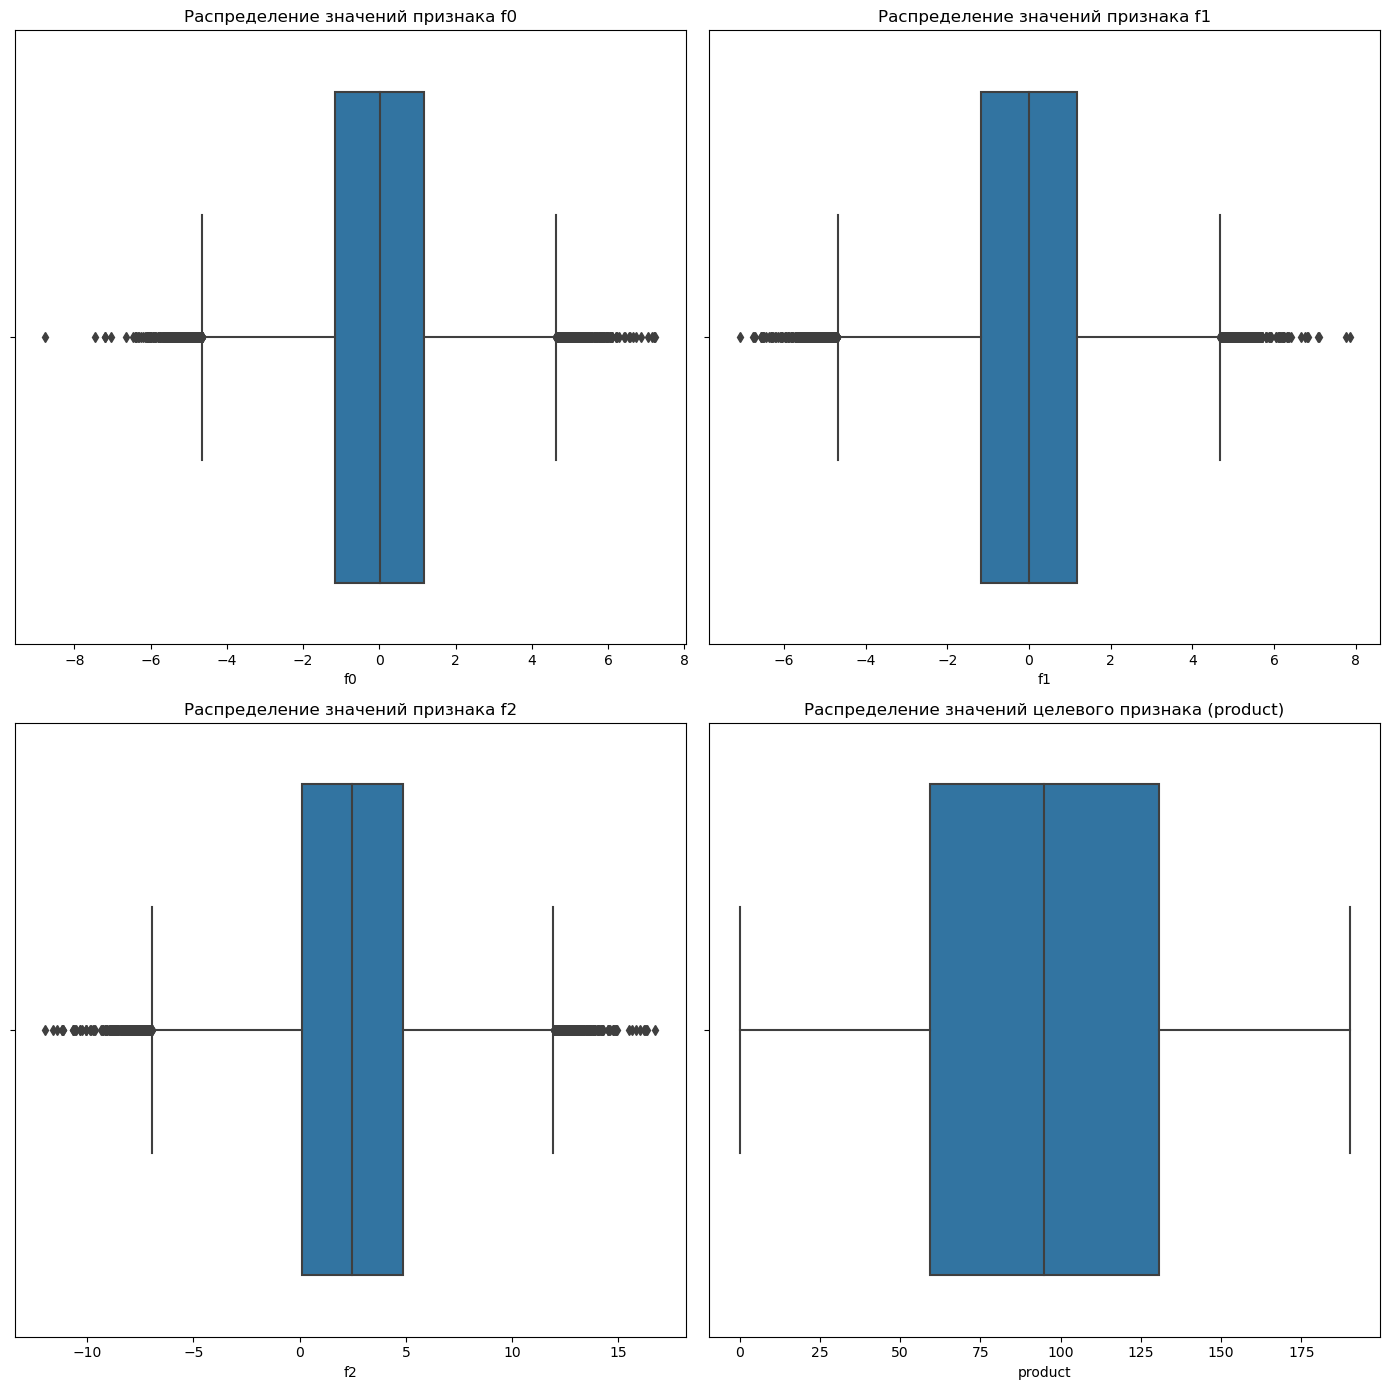

In [9]:
inf(df_geo_2)

В датафрейме 100000 строк и 5 столбцов.  
Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
Из 100000 значений "id" уникальных 99996: присутствуют дубликаты.  
Присутствуют выбросы по признакам "f0", "f1" и "f2".  

**Вывод:**  
1. В датафрейме df_geo_0 100000 строк и 5 столбцов.  
Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
Из 100000 значений "id" уникальных 99990: присутствуют дубликаты.  
Присутствуют выбросы по признаку "f2".  

2. В датафрейме df_geo_1 100000 строк и 5 столбцов.  
Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
Из 100000 значений "id" уникальных 99990: присутствуют дубликаты.  
Присутствуют выбросы по признаку "f2".  

3. В датафрейме df_geo_2 100000 строк и 5 столбцов.  
Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
Из 100000 значений "id" уникальных 99996: присутствуют дубликаты.  
Присутствуют выбросы по признакам "f0", "f1" и "f2".  

### Подготовка данных
<a id="data_preparation"></a>

Удаляем дубликаты по "id":

In [10]:
def drop_dupl(df):
    df = (
        df
        .sort_values(by='product', ascending=True)
        .drop_duplicates(['id'])
        .reset_index(drop=True)
    )
    return df

In [11]:
df_geo_0 = drop_dupl(df_geo_0)
df_geo_1 = drop_dupl(df_geo_1)
df_geo_2 = drop_dupl(df_geo_2)

In [12]:
print('Количество точек в первом регионе: {}'.format(df_geo_0.shape[0]))
print('Количество точек во втором регионе: {}'.format(df_geo_1.shape[0]))
print('Количество точек в третьем регионе: {}'.format(df_geo_2.shape[0]))

Количество точек в первом регионе: 99990
Количество точек во втором регионе: 99996
Количество точек в третьем регионе: 99996


**Вывод:**
1. В каждом датафрейме по 100000 строк и 5 столбцов.  
2. Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
3. Удалены дубликаты по "id".  
4. В результате обработки в датафреймах остались данный по количеству точек:  
- в первом регионе - 99990;  
- во втором регионе - 99996;  
- в третьем регионе - 99996.  

## Обучение и проверка модели
<a id="teach_and_check"></a>

Задаем общее значение параметра "random_state":

In [13]:
RS = np.random.RandomState(5)

Функция обучения модели:

In [14]:
def pred_rmse(df):
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    features_train, features_valid, tadget_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=RS)
    features_train = features_train.reset_index(drop=True)
    features_valid = features_valid.reset_index(drop=True)
    tadget_train = tadget_train.reset_index(drop=True)
    target_valid = target_valid.reset_index(drop=True)
    print('Количество объектов в обучающей выборке: {}'.format(features_train.shape[0]))
    print('Количество объектов в валидационной выборке: {}'.format(features_valid.shape[0]))
    print()
    
    # масштабирование
    def normal(df_train, df_valid):
        numeric = ['f0', 'f1', 'f2']
        
        scaler = StandardScaler()
        scaler.fit(df_train[numeric])
        df_train = df_train.reset_index(drop=True)
        df_train[numeric] = scaler.transform(df_train[numeric])
        df_valid[numeric] = scaler.transform(df_valid[numeric])
        return df_train, df_valid
    
    # обучение
    def learn(df_features_train, df_target_train, df_features_valid, df_target_valid):
        model = LinearRegression()
        model.fit(df_features_train, df_target_train)
        scores = abs(cross_val_score(model, df_features_train, df_target_train, scoring="neg_mean_squared_error", cv=5)) ** 0.5
        final_score = sum(scores) / len(scores)
        target_predict = model.predict(df_features_valid)
        target_predict_mean = target_predict.mean()
        rmse = mean_squared_error(df_target_valid, target_predict) ** 0.5
        return target_predict_mean, rmse, final_score, target_predict
    
    features_train_norm, features_valid_norm = normal(features_train, features_valid)

    target_predict_mean, rmse, final_score, target_predict = learn(
        features_train_norm, tadget_train, features_valid_norm, target_valid)
    print('Средняя оценка качества модели (RMSE) по результатам кросс-валидации: {:.2f}.'.format(final_score))
    print('RMSE модели на валидационной выборке: {:.2f}.'.format(rmse))
    print()
    print('Средний фактический запас сырья: {:.3f}.'.format(target_valid.mean()))
    print('Средний предсказанный запас сырья: {:.3f}.'.format(target_predict_mean))
    
    target_predict = pd.Series(target_predict, name='target_predict')
    
    df_valid = pd.merge(features_valid, target_valid, left_index=True, right_index=True)
    df_valid = pd.merge(df_valid, target_predict, left_index=True, right_index=True)

    return target_valid, target_predict, target_predict_mean

Обучаем модель для первого региона:

In [15]:
target_valid_geo_0, target_predict_geo_0, target_predict_mean_geo_0 = pred_rmse(df_geo_0)

Количество объектов в обучающей выборке: 74992
Количество объектов в валидационной выборке: 24998

Средняя оценка качества модели (RMSE) по результатам кросс-валидации: 37.71.
RMSE модели на валидационной выборке: 37.63.

Средний фактический запас сырья: 92.321.
Средний предсказанный запас сырья: 92.420.


Обучаем модель для второго региона:

In [16]:
target_valid_geo_1, target_predict_geo_1, target_predict_mean_geo_1 = pred_rmse(df_geo_1)

Количество объектов в обучающей выборке: 74997
Количество объектов в валидационной выборке: 24999

Средняя оценка качества модели (RMSE) по результатам кросс-валидации: 0.89.
RMSE модели на валидационной выборке: 0.89.

Средний фактический запас сырья: 69.010.
Средний предсказанный запас сырья: 69.013.


Обучаем модель для третьего региона:

In [17]:
target_valid_geo_2, target_predict_geo_2, target_predict_mean_geo_2 = pred_rmse(df_geo_2)

Количество объектов в обучающей выборке: 74997
Количество объектов в валидационной выборке: 24999

Средняя оценка качества модели (RMSE) по результатам кросс-валидации: 40.02.
RMSE модели на валидационной выборке: 40.17.

Средний фактический запас сырья: 95.166.
Средний предсказанный запас сырья: 94.867.


**Вывод:**
1. Значения RMSE на валидационной выборке: 
- первый регион - 37.57;
- второй регион - 0.89;
- третий регион - 40.00;  

В данных по первому и третьему регионам прослеживается низкая линейная зависимость целевого признака от признаков: высокие значения RMSE.  

2. Средние предсказанные запасы сырья:
- первый регион - 92.260 тысяч тонн;
- второй регион - 69.067 тысяч тонн;
- третий регион - 95.039 тысяч тонн;

## Подготовка к расчёту прибыли
<a id="profit_preparation"></a>

Задаем параметры расчёта прибыли:

In [18]:
BUDGET = 10 * 10**9                       # бюджет на разработку месторождений
CHOOSE_WELLS = 500                        # количество рассматриваемых для выбора объектов
NUMBER_OF_WELLS = 200                     # количество выбранных объектов
BOOTSTRAP_CNT = 1000                      # количество итераций bootstrap
PROFIT_PER_UNIT = 450000                  # доход с единицы продукта
ALPHA = 0.025                             # нижняя граница доверительного интервала

Рассчитываем объём сырья, достаточный для безубыточной разработки новой скважины:

In [19]:
required_volume = BUDGET / (NUMBER_OF_WELLS * PROFIT_PER_UNIT)
print('Объём сырья, достаточный для безубыточной разработки новой скважины: {:.2f} тысяч тонн.'.format(required_volume))

Объём сырья, достаточный для безубыточной разработки новой скважины: 111.11 тысяч тонн.


In [20]:
print('В первом регионе средний объем добычи составляет {:.1%} от объема, необходимого для безубыточной разработки новой скважины.'\
      .format(target_predict_mean_geo_0 / required_volume))
print('Во втором регионе средний объем добычи составляет {:.1%} от объема, необходимого для безубыточной разработки новой скважины.'\
      .format(target_predict_mean_geo_1 / required_volume))
print('В третьем регионе средний объем добычи составляет {:.1%} от объема, необходимого для безубыточной разработки новой скважины.'\
      .format(target_predict_mean_geo_2 / required_volume))

В первом регионе средний объем добычи составляет 83.2% от объема, необходимого для безубыточной разработки новой скважины.
Во втором регионе средний объем добычи составляет 62.1% от объема, необходимого для безубыточной разработки новой скважины.
В третьем регионе средний объем добычи составляет 85.4% от объема, необходимого для безубыточной разработки новой скважины.


Функция расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [21]:
def profit_calculation(target, predict, count):
    probs_sorted = predict.sort_values(ascending=False)
    selected = target[probs_sorted.index][:NUMBER_OF_WELLS]
    profit = (selected - required_volume).sum() * PROFIT_PER_UNIT
    return profit

## Расчёт прибыли и рисков 
<a id="profit"></a>

### Расчёт прибыли для двухсот лучших по прогнозам точек каждого региона
<a id="profit_200_best"></a>

Рассчитываем прибыль с двухсот лучших по предсказаниям точек первого региона:

In [22]:
profit_geo_0 = profit_calculation(target_valid_geo_0, target_predict_geo_0, NUMBER_OF_WELLS)
print('Прибыль с 200-от лучших по прогнозу скважин для первого региона: {:.2f} млрд.'.format(profit_geo_0 / 1000000000))

Прибыль с 200-от лучших по прогнозу скважин для первого региона: 3.24 млрд.


Рассчитываем прибыль с двухсот лучших по предсказаниям точек второго региона:

In [23]:
profit_geo_1 = profit_calculation(target_valid_geo_1, target_predict_geo_1, NUMBER_OF_WELLS)
print('Прибыль с 200-от лучших по прогнозу скважин для второго региона: {:.2f} млрд.'.format(profit_geo_1 / 1000000000))

Прибыль с 200-от лучших по прогнозу скважин для второго региона: 2.42 млрд.


Рассчитываем прибыль с двухсот лучших по предсказаниям точек третьего региона:

In [24]:
profit_geo_2 = profit_calculation(target_valid_geo_2, target_predict_geo_2, NUMBER_OF_WELLS)
print('Прибыль с 200-от лучших по прогнозу скважин для третьего региона: {:.2f} млрд.'.format(profit_geo_2 / 1000000000))

Прибыль с 200-от лучших по прогнозу скважин для третьего региона: 2.60 млрд.


### Расчёт рисков и прибыли для каждого региона
<a id="profit_200_from_500"></a>

Функция расчёта рисков и прибыли:

In [27]:
def bootstrap(target, probabilities):
    values = []
    for i in range(BOOTSTRAP_CNT):
        probabilities_sample = probabilities.sample(n=CHOOSE_WELLS, replace=True, random_state=RS)
        target_sample = target[probabilities_sample.index]
        values.append(profit_calculation(target_sample, probabilities_sample, CHOOSE_WELLS))
    values = pd.Series(values, name='values')
    
    lower = values.quantile(ALPHA)
    higher = values.quantile(1 - ALPHA)

    print('Среднее значение прибыли: {:.1f} млн.'.format(values.mean() / 1000000))
    print('Значение квантиля {}: {:.1f} млн.'.format(ALPHA, lower / 1000000))
    print('Значение квантиля {}: {:.1f} млн.'.format(1 - ALPHA, higher / 1000000))
    print('Вероятность убытков: {:.1%}'.format((values<0).mean()))
    return None

Рассчитываем риски и прибыль для первого региона:

In [28]:
bootstrap(target_valid_geo_0, target_predict_geo_0)

Среднее значение прибыли: 427.0 млн.
Значение квантиля 0.025: -127.7 млн.
Значение квантиля 0.975: 969.1 млн.
Вероятность убытков: 7.0%


Рассчитываем риски и прибыль для второго региона:

In [29]:
bootstrap(target_valid_geo_1, target_predict_geo_1)

Среднее значение прибыли: 534.8 млн.
Значение квантиля 0.025: 118.1 млн.
Значение квантиля 0.975: 954.4 млн.
Вероятность убытков: 0.8%


Рассчитываем риски и прибыль для третьего региона:

In [30]:
bootstrap(target_valid_geo_2, target_predict_geo_2)

Среднее значение прибыли: 421.2 млн.
Значение квантиля 0.025: -146.6 млн.
Значение квантиля 0.975: 936.0 млн.
Вероятность убытков: 7.7%


**Вывод:**
1. Прибыль с 200-от лучших по прогнозу скважин для:  
- первого региона - 3.39 млрд;  
- второго региона - 2.42 млрд;  
- третьего региона - 2.63 млрд;  
2. Данные по прибыли с 200-от лучших по прогнозу скважин из 1000 выборок в 500 точек для первого региона:  
- среднее значение прибыли: 452.9 млн;  
- значение квантиля 0.025: -108.6 млн;  
- значение квантиля 0.975: 956.2 млн;  
- вероятность убытков: 5.2%.  
3. Данные по прибыли с 200-от лучших по прогнозу скважин из 1000 выборок в 500 точек для второго региона:  
- среднее значение прибыли: 530.8 млн;  
- значение квантиля 0.025: 112.4 млн;  
- значение квантиля 0.975: 956.6 млн;  
- вероятность убытков: 0.6%.  
4. Данные по прибыли с 200-от лучших по прогнозу скважин из 1000 выборок в 500 точек для третьего региона:  
- среднее значение прибыли: 392.7 млн;  
- значение квантиля 0.025: -143.0 млн;  
- значение квантиля 0.975: 946.7 млн;  
- вероятность убытков: 8.0%.  
5. Второй регион является приоритетным для инвестирования: наибольшая средняя прибыль с двухсот лучших скважин из тысячи выборок в пятьсот точек и наименьший риск возникновения убытка.

## Общий вывод
<a id="final"></a>

**Загрузка и подготовка данных**  
1. В каждом датафрейме по 100000 строк и 5 столбцов.  
2. Данные поля "id" имеют тип "object", а "f0", "f1", "f2" и "product" - "float64".  
3. Удалены дубликаты по "id".  
4. В результате обработки в датафреймах остались данный по количеству точек:  
- в первом регионе - 99990;  
- во втором регионе - 99996;  
- в третьем регионе - 99996.  

**Обучение и проверка модели**  
1. Значения RMSE на валидационной выборке: 
- первый регион - 37.57;
- второй регион - 0.89;
- третий регион - 40.00;  

В данных по первому и третьему регионам прослеживается низкая линейная зависимость целевого признака от признаков: высокие значения RMSE.  

2. Средние предсказанные запасы сырья:
- первый регион - 92.260 тысяч тонн;
- второй регион - 69.067 тысяч тонн;
- третий регион - 95.039 тысяч тонн;

**Расчёт прибыли**  
1. Прибыль с 200-от лучших по прогнозу скважин для:  
- первого региона - 3.39 млрд;  
- второго региона - 2.42 млрд;  
- третьего региона - 2.63 млрд;  
2. Данные по прибыли с 200-от лучших по прогнозу скважин из 1000 выборок в 500 точек для первого региона:  
- среднее значение прибыли: 452.9 млн;  
- значение квантиля 0.025: -108.6 млн;  
- значение квантиля 0.975: 956.2 млн;  
- вероятность убытков: 5.2%.  
3. Данные по прибыли с 200-от лучших по прогнозу скважин из 1000 выборок в 500 точек для второго региона:  
- среднее значение прибыли: 530.8 млн;  
- значение квантиля 0.025: 112.4 млн;  
- значение квантиля 0.975: 956.6 млн;  
- вероятность убытков: 0.6%.  
4. Данные по прибыли с 200-от лучших по прогнозу скважин из 1000 выборок в 500 точек для третьего региона:  
- среднее значение прибыли: 392.7 млн;  
- значение квантиля 0.025: -143.0 млн;  
- значение квантиля 0.975: 946.7 млн;  
- вероятность убытков: 8.0%.  
5. Второй регион является приоритетным для инвестирования: наибольшая средняя прибыль с двухсот лучших скважин из тысячи выборок в пятьсот точек и наименьший риск возникновения убытка.